**Question 2 Part A**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Acc: {100.*test_correct/test_total:.2f}%')

torch.save(model.state_dict(), 'resnet50_cifar10.pth')

100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Epoch 1/10, Loss: 0.7296, Test Acc: 80.21%
Epoch 2/10, Loss: 0.5779, Test Acc: 79.37%
Epoch 3/10, Loss: 0.5524, Test Acc: 80.59%
Epoch 4/10, Loss: 0.5364, Test Acc: 82.07%
Epoch 5/10, Loss: 0.5216, Test Acc: 82.06%
Epoch 6/10, Loss: 0.5198, Test Acc: 81.92%
Epoch 7/10, Loss: 0.5065, Test Acc: 80.95%
Epoch 8/10, Loss: 0.4966, Test Acc: 82.68%
Epoch 9/10, Loss: 0.4969, Test Acc: 82.80%
Epoch 10/10, Loss: 0.4898, Test Acc: 81.33%


**Question 2 Part B**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

conv1 = nn.Conv2d(3, 32, 3, padding=1).to(device)
conv2 = nn.Conv2d(32, 64, 3, padding=1).to(device)
conv3 = nn.Conv2d(64, 128, 3, padding=1).to(device)
pool = nn.MaxPool2d(2, 2)
fc = nn.Linear(128 * 4 * 4, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(conv1.parameters()) + list(conv2.parameters()) + list(conv3.parameters()) + list(fc.parameters()), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        x = pool(nn.functional.relu(conv1(inputs)))
        x = pool(nn.functional.relu(conv2(x)))
        x = pool(nn.functional.relu(conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        outputs = fc(x)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            x = pool(nn.functional.relu(conv1(inputs)))
            x = pool(nn.functional.relu(conv2(x)))
            x = pool(nn.functional.relu(conv3(x)))
            x = x.view(-1, 128 * 4 * 4)
            outputs = fc(x)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Acc: {100.*test_correct/test_total:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 1.4003, Test Acc: 58.61%
Epoch 2/20, Loss: 1.0146, Test Acc: 67.62%
Epoch 3/20, Loss: 0.8625, Test Acc: 71.04%
Epoch 4/20, Loss: 0.7685, Test Acc: 72.12%
Epoch 5/20, Loss: 0.6982, Test Acc: 74.31%
Epoch 6/20, Loss: 0.6441, Test Acc: 75.15%
Epoch 7/20, Loss: 0.6037, Test Acc: 75.30%
Epoch 8/20, Loss: 0.5623, Test Acc: 76.18%
Epoch 9/20, Loss: 0.5296, Test Acc: 76.80%
Epoch 10/20, Loss: 0.5002, Test Acc: 76.96%
Epoch 11/20, Loss: 0.4768, Test Acc: 77.18%
Epoch 12/20, Loss: 0.4519, Test Acc: 77.39%
Epoch 13/20, Loss: 0.4286, Test Acc: 77.46%
Epoch 14/20, Loss: 0.4036, Test Acc: 77.07%
Epoch 15/20, Loss: 0.3883, Test Acc: 77.82%
Epoch 16/20, Loss: 0.3658, Test Acc: 78.11%
Epoch 17/20, Loss: 0.3496, Test Acc: 77.45%
Epoch 18/20, Loss: 0.3363, Test Acc: 77.57%
Epoch 19/20, Loss: 0.3156, Test Acc: 77.68%
Epoch 20/20, Loss: 0.3106, Test Acc: 77.48%


**Question2 part C**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torchvision.models import resnet50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

teacher_model = resnet50(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)
teacher_model.to(device)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

student_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student_model.to(device)

criterion = nn.CrossEntropyLoss()
kl_criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = teacher_model(images)

        student_logits = student_model(images)

        ce_loss = criterion(student_logits, labels)
        kl_loss = kl_criterion(F.log_softmax(student_logits / 3, dim=1),
                               F.softmax(teacher_logits / 3, dim=1))
        loss = 0.5 * ce_loss + 0.5 * kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    student_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 0.7446, Test Accuracy: 63.66%
Epoch 2/10, Loss: 0.5570, Test Accuracy: 70.04%
Epoch 3/10, Loss: 0.4791, Test Accuracy: 73.67%
Epoch 4/10, Loss: 0.4271, Test Accuracy: 75.73%
Epoch 5/10, Loss: 0.3835, Test Accuracy: 76.33%
Epoch 6/10, Loss: 0.3488, Test Accuracy: 77.09%
Epoch 7/10, Loss: 0.3162, Test Accuracy: 77.39%
Epoch 8/10, Loss: 0.2863, Test Accuracy: 76.20%
Epoch 9/10, Loss: 0.2633, Test Accuracy: 77.06%
Epoch 10/10, Loss: 0.2408, Test Accuracy: 76.98%


**Question 1**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
import glob
import librosa
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import IPython
import zipfile
from PIL import Image

In [29]:

def get_binary_code(binary_codes):
    transitions = 0
    for i in range(len(binary_codes) - 1):
        if binary_codes[i] != binary_codes[i + 1]:
            transitions += 1
    if transitions > 2:
      return 0
    else:
      return int(''.join(map(str,binary_codes)),2)


def get_lbp_image(image, radius=1, n_points=8):
  lbp_image = np.zeros_like(image)
  padded_image = np.pad(image,((radius,radius),(radius,radius)),mode='constant',constant_values=0)
  #lbp_codes = []
  for i in range(radius,image.shape[0]+radius):
    for j in range(radius,image.shape[1]+radius):
      center_pixel = padded_image[i,j]
      binary_codes = []
      for x in range(-radius,radius+1):
        for y in range(-radius,radius+1):
          if x==0 and y==0:
            continue
          neighbor_pixel = padded_image[i+x,j+y]
          if neighbor_pixel > center_pixel:
            binary_codes.append(1)
          else:
            binary_codes.append(0)
      binary_code = get_binary_code(binary_codes)
      #lbp_codes.append(binary_code)
      lbp_image[i-radius,j-radius] = binary_code
  return lbp_image


def get_histogram(image):
  histogram = np.zeros(256)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      pixel_value = image[i,j]
      histogram[pixel_value] += 1
  histogram /= np.sum(histogram)
  return histogram

def get_predicted_label(histogram_test,all_train_images):
  min_distance = float('inf')
  predicted_label = None
  for train_image in all_train_images:
    train_histogram = train_image.histogram
    distance = np.linalg.norm(histogram_test - train_histogram)
    if distance < min_distance:
      min_distance = distance
      predicted_label = train_image.subject_name
  return predicted_label,train_image




In [30]:
class file_name_obj():
  def __init__(self,file_name):
    self.file_name = file_name
    self.subject_name = self.get_subject_name()
    self.image =None
    self.lbp_image = None
    self.histogram = None


  def get_subject_name(self):

    subject_name = self.file_name.split(".")[0]
    return subject_name

In [32]:
folder_path ="/content/drive/MyDrive/AIP/train"
file_names = os.listdir(folder_path)

all_train_images = []


for file_name in file_names:
  _file_name_obj = file_name_obj(file_name)
  image = Image .open(os.path.join(folder_path,file_name))
  image = image.convert('L')
  image = np.array(image)
  _file_name_obj.image = image
  _file_name_obj.lbp_image = get_lbp_image(image, radius=1, n_points=8)
  _file_name_obj.histogram = get_histogram(image)
  all_train_images.append(_file_name_obj)


In [33]:
folder_path ="/content/drive/MyDrive/AIP/test"
file_names = os.listdir(folder_path)

all_test_images = []

success_counter =0
for i,file_name in enumerate(file_names):
  _file_name_obj = file_name_obj(file_name)
  image = Image .open(os.path.join(folder_path,file_name))
  image = image.convert('L')
  image = np.array(image)
  _file_name_obj.image = image
  _file_name_obj.lbp_image = get_lbp_image(image, radius=1, n_points=8)
  _file_name_obj.histogram = get_histogram(image)
  #checking classification accuracy
  predicted_label,matched_trained_image = get_predicted_label(_file_name_obj.histogram,all_train_images)
  if _file_name_obj.subject_name.upper() == predicted_label.upper():
    success_counter+=1
    print(f"correct Classified:Actual:{_file_name_obj.subject_name},Predicted:{predicted_label},Accuracy:{round(success_counter/(i+1),2)}")
  else:
    print(f"Wrong Classified:Actual:{_file_name_obj.subject_name},Predicted:{predicted_label},Accuracy:{round(success_counter/(i+1),2)}")
  all_test_images.append(_file_name_obj)







Wrong Classified:Actual:subject09,Predicted:subject13,Accuracy:0.0
Wrong Classified:Actual:subject15,Predicted:subject07,Accuracy:0.0
correct Classified:Actual:subject08,Predicted:subject08,Accuracy:0.33
correct Classified:Actual:subject10,Predicted:subject10,Accuracy:0.5
correct Classified:Actual:subject14,Predicted:subject14,Accuracy:0.6
Wrong Classified:Actual:subject08,Predicted:subject15,Accuracy:0.5
correct Classified:Actual:subject13,Predicted:subject13,Accuracy:0.57
Wrong Classified:Actual:subject03,Predicted:subject09,Accuracy:0.5
Wrong Classified:Actual:subject07,Predicted:subject06,Accuracy:0.44
correct Classified:Actual:subject01,Predicted:subject01,Accuracy:0.5
Wrong Classified:Actual:subject02,Predicted:subject13,Accuracy:0.45
Wrong Classified:Actual:subject04,Predicted:subject09,Accuracy:0.42
correct Classified:Actual:subject13,Predicted:subject13,Accuracy:0.46
correct Classified:Actual:subject10,Predicted:subject10,Accuracy:0.5
correct Classified:Actual:subject09,Predic

[0.00000000e+00 3.85802469e-05 3.47222222e-04 1.09310700e-03
 1.72325103e-03 1.91615226e-03 2.90637860e-03 0.00000000e+00
 4.08950617e-03 4.29526749e-03 3.66512346e-03 4.12808642e-03
 5.00257202e-03 5.10545267e-03 0.00000000e+00 5.32407407e-03
 4.96399177e-03 5.40123457e-03 5.69701646e-03 5.14403292e-03
 4.66820988e-03 0.00000000e+00 4.56532922e-03 4.28240741e-03
 3.74228395e-03 2.91923868e-03 2.88065844e-03 2.08333333e-03
 0.00000000e+00 2.31481481e-03 1.74897119e-03 1.94187243e-03
 1.90329218e-03 1.98045267e-03 2.70061728e-03 0.00000000e+00
 2.41769547e-03 2.81635802e-03 3.12500000e-03 3.11213992e-03
 3.18930041e-03 3.04783951e-03 0.00000000e+00 2.62345679e-03
 2.43055556e-03 2.63631687e-03 2.72633745e-03 2.22479424e-03
 2.31481481e-03 0.00000000e+00 2.01903292e-03 2.17335391e-03
 2.25051440e-03 2.07047325e-03 2.30195473e-03 2.62345679e-03
 0.00000000e+00 2.08333333e-03 2.30195473e-03 2.41769547e-03
 2.62345679e-03 2.58487654e-03 2.22479424e-03 0.00000000e+00
 2.61059671e-03 2.919238

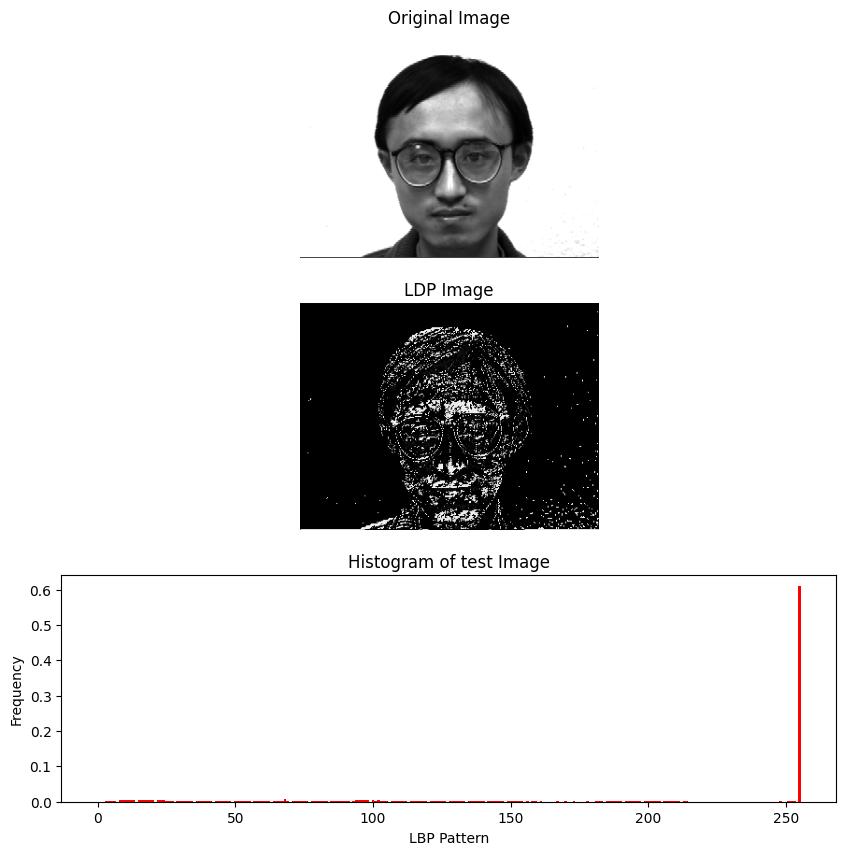

In [34]:
_file_name_obj = all_test_images[2]
fig,axis =plt.subplots(3,1,figsize=(10,10))
axis[0].imshow(_file_name_obj.image,cmap='gray')
axis[0].set_title("Original Image")
axis[0].axis('off')
axis[1].imshow(_file_name_obj.lbp_image,cmap='gray')
axis[1].set_title("LDP Image")
axis[1].axis('off')
print(_file_name_obj.histogram)
_histogram = _file_name_obj.histogram.astype(float)
_histogram/=np.sum(_histogram)

axis[2].bar(np.arange(256), _histogram, width=1, color='red', align='center')
axis[2].set_title("Histogram of test Image")
axis[2].set_xlabel("LBP Pattern")
axis[2].set_ylabel("Frequency")
plt.show()




Eucliedan distance forsubject01:0.033113800478886374
Eucliedan distance forsubject02:0.14910211356100095
Eucliedan distance forsubject03:0.22608752539817698


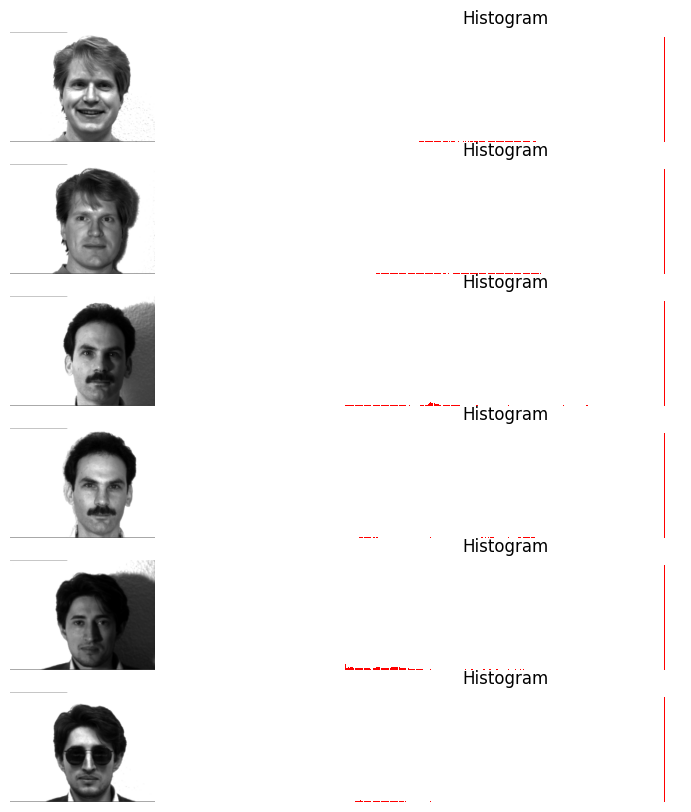

In [37]:


subject ={"subject01":[],"subject02":[],"subject03":[]}

subplot=6
for _obj in all_test_images:
  for key in subject.keys():
    if (_obj.subject_name.lstrip("0").upper() )== key.lstrip("0").upper():
      subject[key].append(_obj)

fig,axis =plt.subplots(subplot,2,figsize=(10,10))
i=0
for key in subject.keys():
  histogram=[]
  for _obj in subject[key]:
    axis[i,0].imshow(_obj.image,cmap='gray')
    axis[i,0].axis('off')
    axis[i,1].bar(np.arange(256), _obj.histogram, width=1, color='red', align='center')
    axis[i,1].set_title("Histogram")
    axis[i,1].axis('off')
    i+=1
    histogram.append(_obj.histogram)
  distance = np.linalg.norm(histogram[0] - histogram[1])
  print(f"Eucliedan distance for{key}:{distance}")
plt.show()



(-13.3, 268.3, 0.0, 0.5707889660493828)

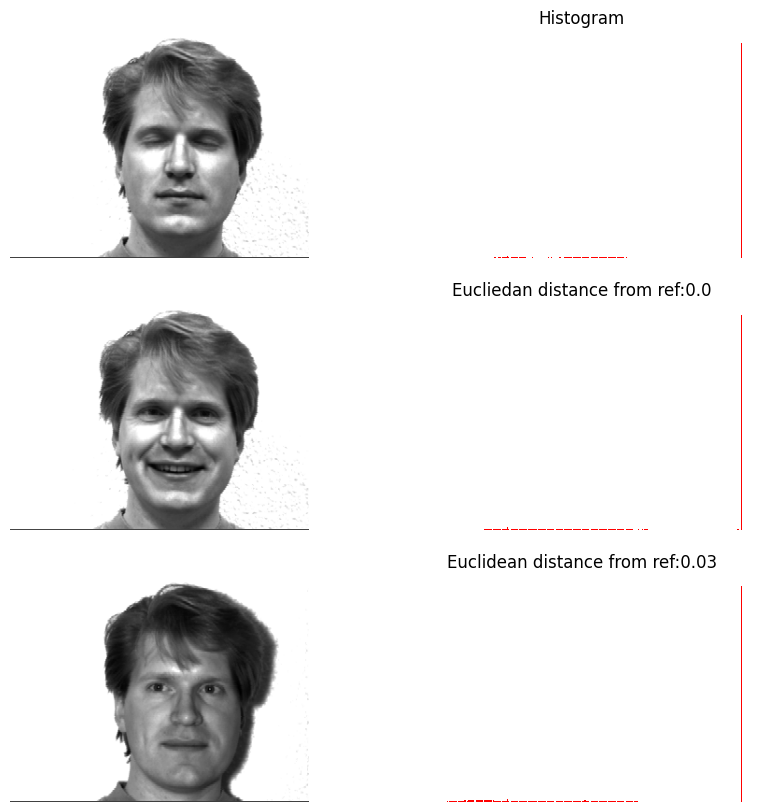

In [40]:

subject ={"subject01":{"illumination":[],"reference":[]}}
subplot=3

for _obj in all_train_images:
  for key in subject.keys():
    if (_obj.subject_name.lstrip("0").upper() )== key.lstrip("0").upper():
      if (_obj.file_name.lstrip("0").upper().find("NORMAL")):
        subject[key]["reference"].append(_obj)

for _obj in all_test_images:
  for key in subject.keys():
    if (_obj.subject_name.lstrip("0").upper() )== key.lstrip("0").upper():
      subject[key]["illumination"].append(_obj)

ref_obj = subject["subject01"]["reference"][0]
illu_obj_1 = subject["subject01"]["illumination"][0]
illu_obj_2 = subject["subject01"]["illumination"][1]
fig,axis =plt.subplots(subplot,2,figsize=(10,10))
axis[0,0].imshow(ref_obj.image,cmap='gray')
axis[0,0].axis('off')
axis[0,1].bar(np.arange(256), ref_obj.histogram, width=1, color='red', align='center')
axis[0,1].set_title("Histogram")
axis[0,1].axis('off')

distance = round(np.linalg.norm(illu_obj_1.histogram - ref_obj.histogram),2)
axis[1,0].imshow(illu_obj_1.image,cmap='gray')
axis[1,0].axis('off')
axis[1,1].bar(np.arange(256), illu_obj_1.histogram, width=1, color='red', align='center')
axis[1,1].set_title(f"Eucliedan distance from ref:{distance}")
axis[1,1].axis('off')



axis[2,0].imshow(illu_obj_2.image,cmap='gray')
axis[2,0].axis('off')
axis[2,1].bar(np.arange(256), illu_obj_2.histogram, width=1, color='red', align='center')
distance = round(np.linalg.norm(illu_obj_2.histogram - ref_obj.histogram),2)
axis[2,1].set_title(f"Euclidean distance from ref:{distance}")
axis[2,1].axis('off')




